<a href="https://colab.research.google.com/github/Raashidh-Rizvi/Brain-Tumor-Detection/blob/main/IT24102388_Handling_Missing_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted in 4.26 seconds
Checking parent directory: /content/drive/MyDrive/Colab Notebooks/brain_tumor_project
Contents of parent folder: ['brain_tumor_project']
Searching for subfolder with Training/Testing...
Checking brain_tumor_project: ['Testing', 'Training']
Found Training/Testing in subfolder: /content/drive/MyDrive/Colab Notebooks/brain_tumor_project/brain_tumor_project
Dataset folders: ['Testing', 'Training']
Initial image counts: {'Training': {'no_tumor': 395, 'pituitary_tumor': 827, 'meningioma_tumor': 822, 'glioma_tumor': 826}, 'Testing': {'no_tumor': 105, 'pituitary_tumor': 74, 'meningioma_tumor': 115, 'glioma_tumor': 100}}


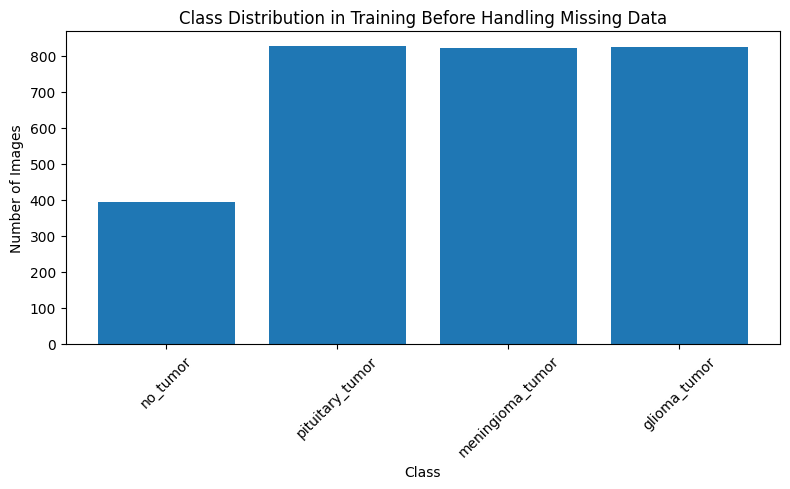

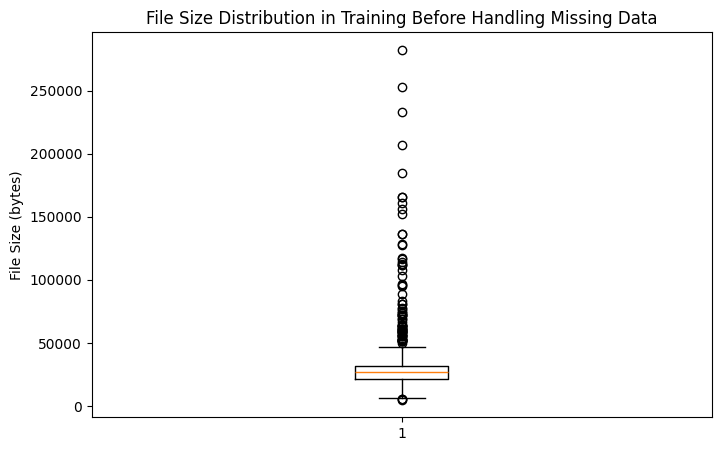

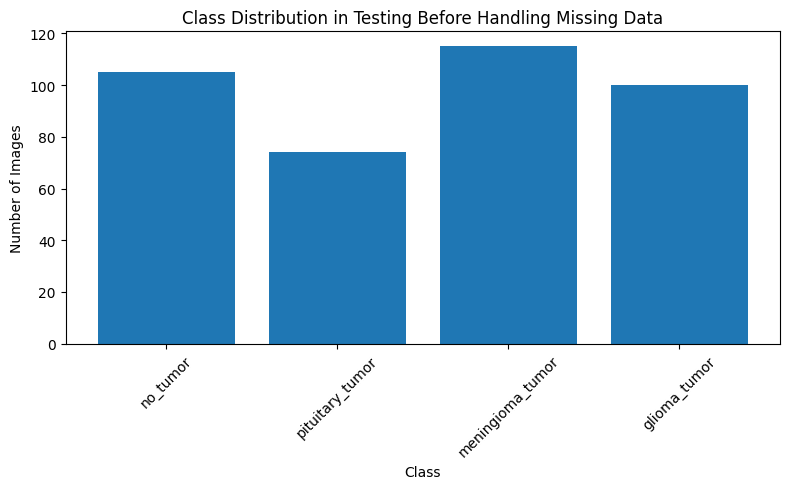

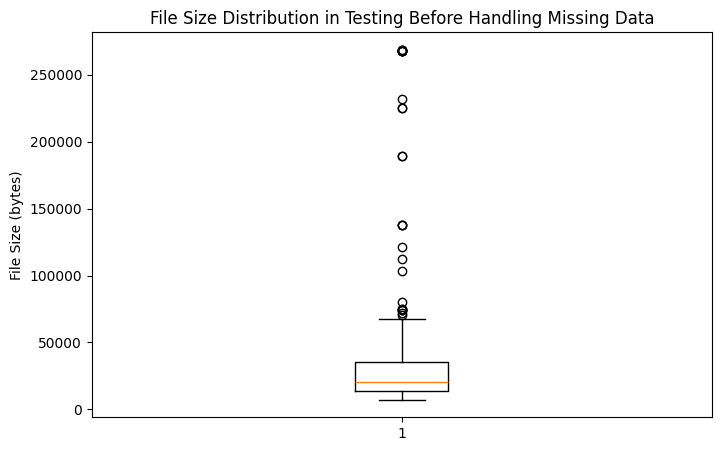

Total valid images after handling: 3264
Image counts after handling missing data: {'Training': Counter({'pituitary_tumor': 827, 'glioma_tumor': 826, 'meningioma_tumor': 822, 'no_tumor': 395}), 'Testing': Counter({'meningioma_tumor': 115, 'no_tumor': 105, 'glioma_tumor': 100, 'pituitary_tumor': 74})}


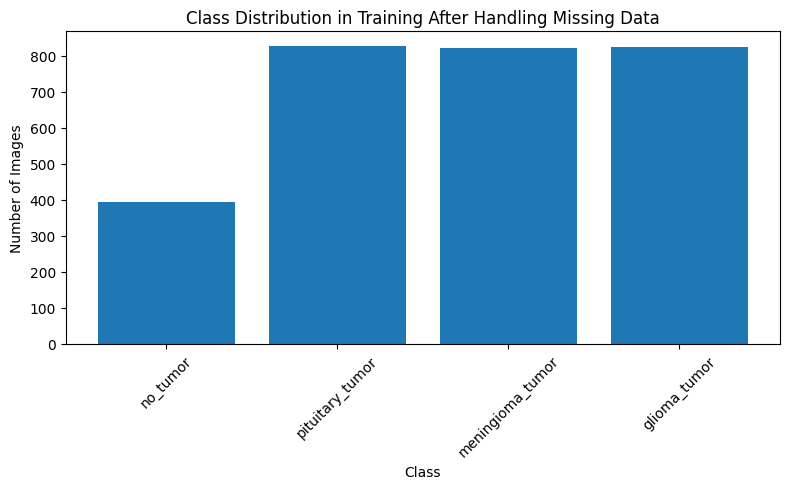

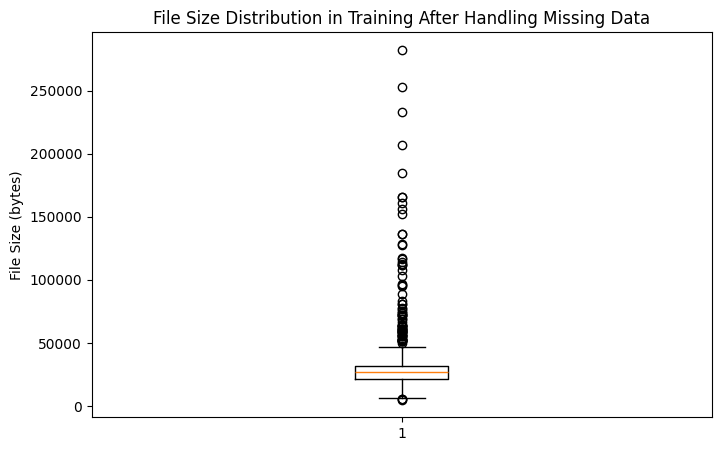

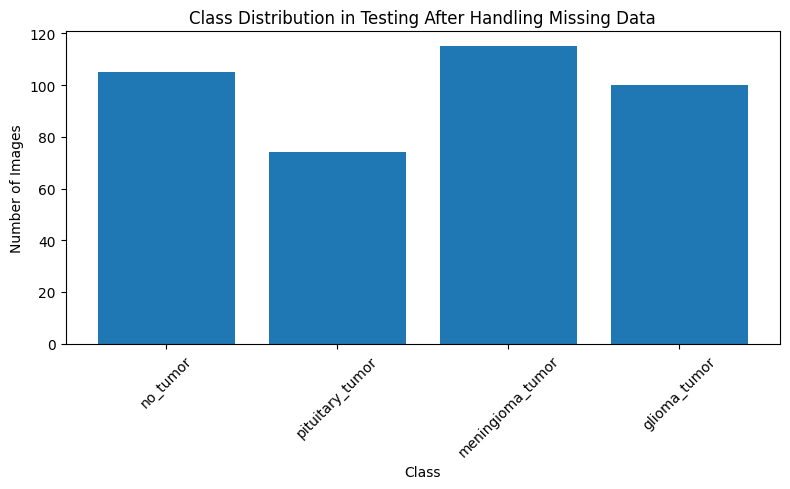

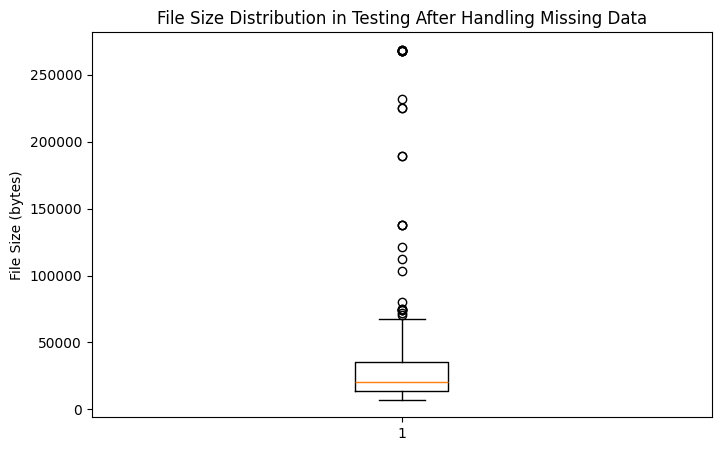

In [ ]:
# Install required library (OpenCV) if not present
!pip install opencv-python-headless -q

# Import necessary libraries
import os
import cv2
import matplotlib.pyplot as plt
from google.colab import drive
from collections import Counter
import time
import numpy as np

# Step 1: Mount Google Drive
print("Mounting Google Drive...")
start_time = time.time()
try:
    drive.mount('/content/drive')
    mount_time = time.time() - start_time
    print(f"Drive mounted in {mount_time:.2f} seconds")
except Exception as e:
    print(f"Error mounting Drive: {e}. Please ensure you authorize the connection.")
    exit()

# Step 2: Define and verify the dataset path
parent_dir = '/content/drive/MyDrive/Colab Notebooks/brain_tumor_project'
print(f"Checking parent directory: {parent_dir}")
if not os.path.exists(parent_dir):
    print(f"Error: Parent path {parent_dir} not found. Please verify this folder exists in Google Drive.")
    exit()
extracted_contents = os.listdir(parent_dir)
print("Contents of parent folder:", extracted_contents)

# Automatically determine data_dir
data_dir = None
if all(split in extracted_contents for split in ['Training', 'Testing']):
    data_dir = parent_dir
    print(f"Found Training/Testing directly in {parent_dir}")
else:
    print("Searching for subfolder with Training/Testing...")
    for item in extracted_contents:
        item_path = os.path.join(parent_dir, item)
        if os.path.isdir(item_path):
            sub_contents = os.listdir(item_path)
            print(f"Checking {item}: {sub_contents}")
            if all(split in sub_contents for split in ['Training', 'Testing']):
                data_dir = item_path
                print(f"Found Training/Testing in subfolder: {data_dir}")
                break
if data_dir is None or not os.path.exists(data_dir):
    print("Error: Could not determine valid dataset path. Available folders:", extracted_contents)
    print("Please ensure the folder contains 'Training' and 'Testing' subfolders.")
    exit()
print("Dataset folders:", os.listdir(data_dir))

# Step 3: Initial EDA - Count images before handling missing data
splits = ['Training', 'Testing']
classes = ['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']  # Updated classes
initial_counts = {split: {} for split in splits}
image_sizes = {split: [] for split in splits}  # For box plots
for split in splits:
    split_path = os.path.join(data_dir, split)
    if os.path.exists(split_path):
        for cls in classes:
            class_path = os.path.join(split_path, cls)
            if os.path.exists(class_path):
                image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.JPG'))]
                initial_counts[split][cls] = len(image_files)
                for img_file in image_files:
                    img_path = os.path.join(class_path, img_file)
                    try:
                        img_size = os.path.getsize(img_path)  # Size in bytes
                        image_sizes[split].append(img_size)
                    except Exception as e:
                        print(f"Error getting size for {img_path}: {e}")
print("Initial image counts:", initial_counts)

# Visualize initial distribution with bar and box plots
for split in splits:
    if initial_counts[split]:  # Bar plot for counts
        plt.figure(figsize=(8, 5))  # Adjusted size for multiple classes
        plt.bar(initial_counts[split].keys(), initial_counts[split].values())
        plt.title(f"Class Distribution in {split} Before Handling Missing Data")
        plt.xlabel("Class")
        plt.ylabel("Number of Images")
        plt.xticks(rotation=45)  # Rotate labels for readability
        plt.tight_layout()
        plt.show()
    else:
        print(f"No data to plot for {split} (bar plot)")
    if image_sizes[split]:  # Box plot for file sizes
        plt.figure(figsize=(8, 5))
        plt.boxplot(image_sizes[split])
        plt.title(f"File Size Distribution in {split} Before Handling Missing Data")
        plt.ylabel("File Size (bytes)")
        plt.show()
    else:
        print(f"No data to plot for {split} (box plot)")

# Step 4: Handle missing data
valid_images = {split: [] for split in splits}
valid_labels = {split: [] for split in splits}
for split in splits:
    split_path = os.path.join(data_dir, split)
    if os.path.exists(split_path):
        for cls in classes:
            class_path = os.path.join(split_path, cls)
            if os.path.exists(class_path):
                image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.JPG'))]
                for img_file in image_files:
                    img_path = os.path.join(class_path, img_file)
                    try:
                        img = cv2.imread(img_path)
                        if img is None:
                            raise ValueError("Image is corrupted")
                        valid_images[split].append(img_path)
                        valid_labels[split].append(cls)
                    except Exception as e:
                        print(f"Removing missing/corrupted image in {split}: {img_path} (Error: {e})")

print(f"Total valid images after handling: {sum(len(valid_images[split]) for split in splits)}")

# Step 5: Post-handling EDA
valid_counts = {split: Counter(valid_labels[split]) for split in splits}
print("Image counts after handling missing data:", valid_counts)

# Visualize post-handling distribution with bar and box plots
for split in splits:
    if valid_counts[split]:  # Bar plot for counts
        plt.figure(figsize=(8, 5))
        plt.bar(valid_counts[split].keys(), valid_counts[split].values())
        plt.title(f"Class Distribution in {split} After Handling Missing Data")
        plt.xlabel("Class")
        plt.ylabel("Number of Images")
        plt.xticks(rotation=45)  # Rotate labels for readability
        plt.tight_layout()
        plt.show()
    else:
        print(f"No data to plot for {split} (bar plot)")
    if image_sizes[split]:  # Box plot for file sizes
        plt.figure(figsize=(8, 5))
        plt.boxplot(image_sizes[split])
        plt.title(f"File Size Distribution in {split} After Handling Missing Data")
        plt.ylabel("File Size (bytes)")
        plt.show()
    else:
        print(f"No data to plot for {split} (box plot)")